<a href="https://colab.research.google.com/github/paolaserra/Algorithms-for-massive-datasets/blob/main/Copia_di_ADM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#starting the project

In [3]:
# upload token file kaggle.json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giuliahadjiandrea","key":"fc0ce37d8f89c0421a66fda0695b7b94"}'}

In [4]:
# move the token file to the ./kaggle directory
! mkdir /root/.kaggle   
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### **Access Kaggle API, download the "Old Newspapers" dataset and unzip it**

In [5]:
# authenticate to the Kaggle API
!pip install kaggle
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [6]:
# download and unzip "Old Newspapers" dataset

!kaggle datasets download -d alvations/old-newspapers

 99% 2.04G/2.05G [00:16<00:00, 128MB/s]
100% 2.05G/2.05G [00:16<00:00, 130MB/s]


In [7]:
!unzip old-newspapers.zip

Archive:  old-newspapers.zip
  inflating: old-newspaper.tsv       


### **Initialize a SparkContext object**


In [8]:
# check number of available cores

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [9]:
# initialize a SparkContext object 

! pip install pyspark

import pyspark
sc = pyspark.SparkContext()

     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 64.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=58f6f743a00743c5c1f2b8d797407eb1528361d4ec39192e3c3f8a9c3ce7cb81
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [10]:
#install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null  


In [11]:
# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz


In [12]:
# unzip the spark file to the current folder
!tar xf spark-3.0.2-bin-hadoop3.2.tgz

#install findspark
!pip install -q findspark

In [13]:
# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop3.2"

In [14]:
import findspark
findspark.init("spark-3.0.2-bin-hadoop3.2")  #SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

**PREPROCESSING**

Content
The columns of each row in the .tsv file are:

Langauge: Language of the text.

Source: Newspaper from which the text is from.

Date: Date of the article that contains the text.

Text: Sentence/paragraph from the newspaper


In [15]:
#DATASET to DF
import pandas
df = spark.read.csv("/content/old-newspaper.tsv", sep=r'\t', header=True)

In [16]:
df.head(1)

[Row(Language='Afrikaans', Source='republikein.com.na', Date='2011/09/14', Text='Die veranderinge aan die Britsgeboude Avensis sluit in hersiene stilering aan die buitekant, wat n voorkantontwerp ingevolge Toyota se nuwe ontwerpstyl insluit.')]

In [17]:
# create an RDD from the "Old Newspapers" dataset and display the first instance

newsRDD = sc.textFile("old-newspaper.tsv", 2)  #min partions
newsRDD.take(1)

['Language\tSource\tDate\tText']

In [18]:
newsRDD.take(10)

['Language\tSource\tDate\tText',
 'Afrikaans\trepublikein.com.na\t2011/09/14\tDie veranderinge aan die Britsgeboude Avensis sluit in hersiene stilering aan die buitekant, wat n voorkantontwerp ingevolge Toyota se nuwe ontwerpstyl insluit.',
 'Afrikaans\trepublikein.com.na\t2011/01/20\tDuitsland se mans- en vrouespanne is die afgelope twee jaar die verdedigende kampioene. Beide Namibië se spanne is hard aan die voorberei vir die wêreldtoernooi wat van 8 tot 13 Februarie plaasvind. Die Regering het vroeg in verlede maand N$1,2 miljoen aan die Namibiese Hokkiefederasie (NHF) beskikbaar gestel om al die koste te dra vir die voorbereiding van die twee spanne vir die Wêreldbeker.',
 'Afrikaans\tsake24.com\t2009/11/28\tMnr. Estienne de Klerk, uitvoerende direkteur van Growthpoint, die land se grootste genoteerde ?eiendomsgroep, het Vrydag aan ?Sake24 gesê die maatskappy sal sekerlik belangstel om die V&A te koop as hy die kans kry.',
 'Afrikaans\tsake24.com\t2009/11/12\tMustek is se finansiël

In [19]:
def split_row(x):

  tup = x.split('''\t''')
  
  date = tup[2]
  year = date[:4]  

  return (tup[0], year, tup[3])

In [20]:
subRDD = newsRDD.map(split_row)
subRDD.take(1)

[('Language', 'Date', 'Text')]

In [21]:
#count by language

subRDD.map(lambda t: t[0]).countByValue()   

defaultdict(int,
            {'Afrikaans': 152312,
             'Albanian': 228553,
             'Amharic': 32553,
             'Arabic': 202461,
             'Armenian': 156586,
             'Azerbaijan': 140995,
             'Bengali': 58998,
             'Bosnian': 181370,
             'Catalan': 81893,
             'Chinese (Simplified)': 682472,
             'Chinese (Traditional)': 333735,
             'Croatian': 227317,
             'Czech': 276881,
             'Danish': 887016,
             'Dutch': 232176,
             'English': 1010242,
             'Farsi': 306846,
             'Finnish': 485758,
             'French': 358001,
             'Galician': 227073,
             'Georgian': 164614,
             'German': 244743,
             'Greek': 230405,
             'Hebrew': 199047,
             'Hindi': 115445,
             'Hungarian': 245685,
             'Icelandic': 39093,
             'Indonesian': 781521,
             'Italian': 169630,
             'Japanese': 3129

In [22]:
# count by years

subRDD.map(lambda t: t[1]).countByValue()

defaultdict(int,
            {'1970': 6,
             '2000': 6075,
             '2001': 7811,
             '2002': 6183,
             '2003': 8452,
             '2004': 20091,
             '2005': 77733,
             '2006': 169678,
             '2007': 369179,
             '2008': 687741,
             '2009': 1494895,
             '2010': 3207680,
             '2011': 7247763,
             '2012': 2812367,
             '2013': 380469,
             'Date': 1,
             'UNKN': 309918})

In [23]:
# look directly at those with year = 'Date' or year = '1970'

subRDD.filter(lambda t: t[1]=='Date' or t[1]=='1970') \
      .collect()

[('Language', 'Date', 'Text'),
 ('French',
  '1970',
  "Habitué depuis deux ans à faire venir des attaquants au mercato hivernal (Quercia en 2008 et Birsa en 2009), Jean Fernandez justifie les arrivées de Jo-Gook et Fall comme des choix « d'avenir ». Et éclaire sur la capacité de ces joueurs à réussir à court terme. « L'expérience me fait dire qu'il y a plus d'échecs que de réussite au mercato d'hiver. Lorsque j'étais à Marseille, Maoulida et Pagis avaient été de bonnes recrues »."),
 ('French',
  '1970',
  "Deux joueurs qui n'ont rien coûté, ou presque, à l'AJA fidèle à sa stratégie de recruter malin. Jo-Gook, auteur d'une apparition en Coupe de France et une en Ligue 1, a confirmé que « le Patriot », comme il est surnommé en Corée du Sud, aura besoin de quelques mois d'adaptation."),
 ('French',
  '1970',
  "Ce que l'on sait, d'ores-et-déjà, c'est que Jelen (en fin de contrat en juin) a peu de chances d'en faire partie. La tendance de l'hiver ne sera peut-être pas celle de l'été, cer

In [24]:
# look at the language in which the ones with unknown date were written

subRDD.filter(lambda t: t[1]=='UNKN') \
      .map(lambda t: t[0]) \
      .countByValue()  # all in Spanish

defaultdict(int, {'Spanish': 309918})

In [25]:
textRDD = subRDD.filter(lambda x: x[0]=='French') \
          .map(lambda t: t[0]) \
          .countByValue()

In [26]:
df.show()


+---------+------------------+----------+--------------------+
| Language|            Source|      Date|                Text|
+---------+------------------+----------+--------------------+
|Afrikaans|republikein.com.na|2011/09/14|Die veranderinge ...|
|Afrikaans|republikein.com.na|2011/01/20|Duitsland se mans...|
|Afrikaans|        sake24.com|2009/11/28|Mnr. Estienne de ...|
|Afrikaans|        sake24.com|2009/11/12|Mustek is se fina...|
|Afrikaans|        sake24.com|2011/02/04|nadat LMS se raad...|
|Afrikaans|       praag.co.za|2011/06/09|Hierdie hersirkul...|
|Afrikaans|     rapport.co.za|2011/07/15|Volgens ao. Novem...|
|Afrikaans|republikein.com.na|2011/05/20|Die plant is beso...|
|Afrikaans|republikein.com.na|2011/10/19|Dit volg op twee ...|
|Afrikaans|       praag.co.za|2009/06/01|Daarom moet 'n Af...|
|Afrikaans|        sake24.com|2011/03/14|Trusts word nie i...|
|Afrikaans|        sake24.com|2009/11/28|Dit was ook duide...|
|Afrikaans|republikein.com.na|2011/07/14|Na n oorlog va

In [27]:
re #Regular expressions are text matching patterns described with a formal syntax.

NameError: ignored

In [ ]:
textRDD = subRDD.filter(lambda x: x[0]=='French').countByValue()


print(textRDD)

In [ ]:
print(textRDD)

In [28]:
textRDD = subRDD.filter(lambda x: x[0]=='English')

In [29]:
textRDD.take(5)

[('English', '2012', "He wasn't home alone, apparently."),
 ('English',
  '2011',
  'The St. Louis plant had to close. It would die of old age. Workers had been making cars there since the onset of mass automotive production in the 1920s.'),
 ('English',
  '2012',
  "WSU's plans quickly became a hot topic on local online sites. Though most people applauded plans for the new biomedical center, many deplored the potential loss of the building."),
 ('English',
  '2011',
  'The Alaimo Group of Mount Holly was up for a contract last fall to evaluate and suggest improvements to Trenton Water Works. But campaign finance records released this week show the two employees donated a total of $4,500 to the political action committee (PAC) Partners for Progress in early June. Partners for Progress reported it gave more than $10,000 in both direct and in-kind contributions to Mayor Tony Mack in the two weeks leading up to his victory in the mayoral runoff election June 15.'),
 ('English',
  '2011',


In [30]:
textRDD = textRDD.sample(withReplacement = False, fraction = 0.1, seed = 1262).repartition(2)  

In [31]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords

from numpy import unique
from string import punctuation

def preprocess(tup):

  ### ARGS
  # tup = (language, date, text)

  ### OUTPUT
  # list of lemmatized tokens in the text field

  ### REQUIRES
  # libraries: nltk, re, numpy.unique, string.punctuation
  # modules (nltk): stopwords, punkt, wordnet 

  if tup[0] == 'English':
    sw = stopwords.words("english") + list(punctuation) + ["n't", "'m", "'d", "'re", "'s","'ve", "'ll", '``', "''", "--", '“', '’','”','...',"«", "»", "–"]
  else:
    sw = stopwords.words("italian") + list(punctuation) + ["«", "»", "–",'``', "''", "--", '“', '’','”','...']

  text = re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', tup[2])

  lemmatizer = nltk.WordNetLemmatizer()
  tokenized_text = nltk.word_tokenize(text.lower())
  tokenized_text = list(unique(tokenized_text))

  return [lemmatizer.lemmatize(w) for w in tokenized_text if w not in sw]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [32]:
text_tokenized = textRDD.map(preprocess)

In [34]:
text_tokenized.take(5)

[['even',
  'game',
  'kept',
  'like',
  'looked',
  'never',
  'onerun',
  'pitching',
  'said',
  'scoreboard'],
 ['accepting',
  'adding',
  'already',
  'assistance',
  'begun',
  'change',
  'commission',
  'customer',
  'illinois',
  'leadership',
  'making',
  'new',
  'prepaidtuition',
  'program',
  'safeguard',
  'say',
  'stopped',
  'student'],
 ['also',
  'board',
  'budget',
  'concern',
  'cut',
  'expressed',
  'fund',
  'funding',
  'general',
  'get',
  'going',
  'member',
  'much',
  'per',
  'reducing',
  'saying',
  'school',
  'soup',
  'student',
  'thin',
  'time',
  'title',
  'wrong'],
 ['2011',
  'abe',
  'agency',
  'agent',
  'also',
  'basis',
  'brandon',
  'brown',
  'chansi',
  'dimitri',
  'doled',
  'elam',
  'eric',
  'factor',
  'floyd',
  'free',
  'honor',
  'jackson',
  'jason',
  'lawrence',
  'loss',
  'lost',
  'matt',
  'net',
  'patterson',
  'pick',
  'playing',
  'postseason',
  'previous',
  'roth',
  'salary',
  'signed',
  'stuckey',


In [43]:
textRDD.take(1), text_tokenized.take(1)

([('English',
   '2009',
   '"""I kept pitching like it was a one-run game,"" he said. ""I never even looked at the scoreboard."""')],
 [['even',
   'game',
   'kept',
   'like',
   'looked',
   'never',
   'onerun',
   'pitching',
   'said',
   'scoreboard']])

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

(0.0, 120.0)

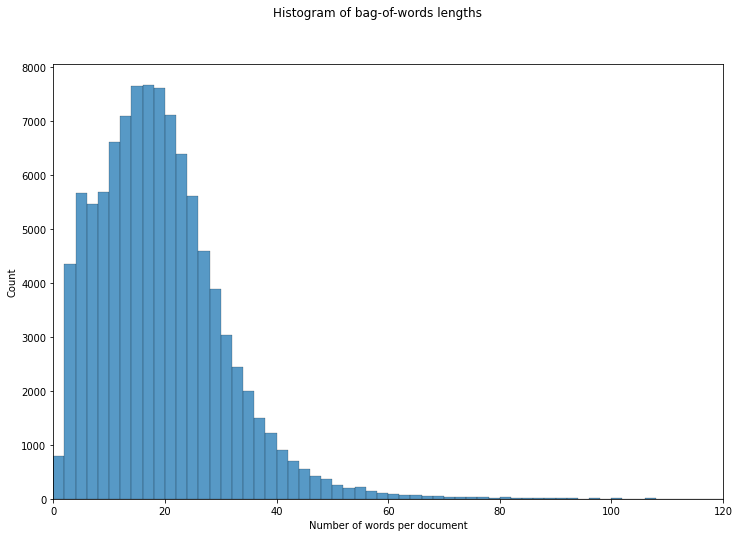

In [50]:
lengths = text_tokenized.map(len) \
                       .collect()

f, ax = plt.subplots(figsize = (12,8))
sns.histplot(data = lengths, binwidth = 2, ax = ax)
ax.set_xlabel("Number of words per document")
f.suptitle("Histogram of bag-of-words lengths")
plt.xlim([0, 120])


togli quelli che sono vuoti? cosi non vengono contati nel processo e fai vedere esempio di uno vuoto.

In [49]:
text_tokenized.map(len).countByValue()

defaultdict(int,
            {0: 36,
             1: 761,
             2: 2093,
             3: 2258,
             4: 2965,
             5: 2708,
             6: 2789,
             7: 2676,
             8: 2759,
             9: 2929,
             10: 3232,
             11: 3377,
             12: 3474,
             13: 3620,
             14: 3760,
             15: 3883,
             16: 3936,
             17: 3738,
             18: 3858,
             19: 3757,
             20: 3637,
             21: 3470,
             22: 3329,
             23: 3057,
             24: 2959,
             25: 2646,
             26: 2425,
             27: 2174,
             28: 2011,
             29: 1870,
             30: 1575,
             31: 1455,
             32: 1311,
             33: 1135,
             34: 1025,
             35: 975,
             36: 774,
             37: 723,
             38: 606,
             39: 604,
             40: 452,
             41: 453,
             42: 387,
             43